In [392]:
import rom_operator_inference as opinf

import pickle
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

import itertools

In [393]:
# !pip install git+https://github.com/Willcox-Research-Group/rom-operator-inference-Python3.git

In [394]:
chosen_columns = ['p', 'U:2']
sets = ['train', 'val', 'test']

input_files = [(dataset, column) for dataset in sets for column in chosen_columns]

In [395]:
input_files

[('train', 'p'),
 ('train', 'U:2'),
 ('val', 'p'),
 ('val', 'U:2'),
 ('test', 'p'),
 ('test', 'U:2')]

In [396]:
tables = {}
for i in input_files:
    with open(f'{i[0]}_{i[1]}.pkl', 'rb') as f:        
        tables[f'{i[0]}_{i[1]}'] = pickle.load(f)

## Plotting the mean pressure and speed

In [397]:
import pandas as pd
v_inlet_bc = pd.read_csv("v_inlet_bc.csv")

In [398]:
tables['train_p']

array([[3.5136e+04, 6.4038e+03, 3.5120e+04, ..., 3.5084e+04, 0.0000e+00,
        1.5702e+01],
       [1.2834e+04, 2.2456e+03, 1.2833e+04, ..., 1.2831e+04, 0.0000e+00,
        4.8228e-01],
       [5.3562e+03, 9.5028e+02, 5.3558e+03, ..., 5.3546e+03, 0.0000e+00,
        6.2243e-01],
       ...,
       [1.6029e+03, 2.8929e+02, 1.6018e+03, ..., 1.6009e+03, 0.0000e+00,
        6.2291e-01],
       [1.6191e+03, 2.9222e+02, 1.6180e+03, ..., 1.6170e+03, 0.0000e+00,
        6.3177e-01],
       [1.6352e+03, 2.9532e+02, 1.6341e+03, ..., 1.6331e+03, 0.0000e+00,
        6.4122e-01]])

In [401]:
# pure copy
N_COMPONENTS = 12
DELTA_T = 1e-4 # step of a time

According to the https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/blob/main/docs/content/tutorials/basics.ipynb, the matrix must be `space` $\times$ `time`

In [402]:
for t in tables:
    tables[t] = tables[t].T

In [403]:
assert tables['train_p'].shape[0] > tables['train_p'].shape[1]   # space is larger than time

In [404]:
all_pressures = np.concatenate([tables['train_p'], tables['val_p'], tables['test_p']],axis=1)
all_pressures.shape

(17183, 999)

In [405]:
all_pressures_mean = all_pressures.mean(0)

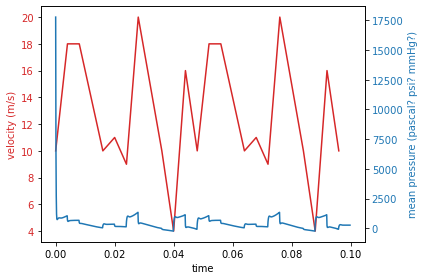

In [406]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('velocity (m/s)', color=color)
ax1.plot(v_inlet_bc['t'], v_inlet_bc['Uz'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('mean pressure (pascal? psi? mmHg?)', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,0.0999,1e-4), all_pressures_mean)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [407]:
all_pressures_mean.argmin(), all_pressures_mean.min(), all_pressures.max()

(399, -243.3009990142757, 35232.0)

In [408]:
# todo negative pressure?

## Scale and stack data

Scale separately for each feature, s.t they have 0 mean, 1 std. Then stacking `[rho_0, v_0, rho_1, v_1, … , rho_n, v_n]` to a `train_data`. The shape would be (`space` $\times$ `num_ft`, `time`)

$$\begin{bmatrix} k_{1,1} & k_{1,2} & \cdots & k_{1,n} \\ nut_{1,1} & k_{1,2} & \cdots & nut_{1,n} \\ \omega_{1,1} & \omega_{1,2} & \cdots & \omega_{1,n} \\  p_{1,1} & p_{1,2} & \cdots & p_{1,n} \\  U:0_{1,1} & U:0_{1,2} & \cdots & U:0_{1,n} \\  U:1_{1,1} & U:1_{1,2} & \cdots & U:1_{1,n} \\  U:2_{1,1} & U:2_{1,2} & \cdots & U:2_{1,n} \\ \vdots & \vdots & \vdots & \vdots \\ U:2_{m,1} & U:2_{m,2} & \cdots & U:2_{m,n} \end{bmatrix}  (1)
$$
with $m$ is space and $n$ is time

In [409]:
def normalize(timeframes):
    '''
    At t=0, get the mean and std through spacial dimension
    '''
    mean = timeframes[:, 0].mean()
    std = timeframes[:, 0].std()
    print(mean, std)
    return (timeframes - mean) / std, mean, std

In [410]:
normed_data, means, stds = {}, {}, {}
for key in tables:
    if key.startswith('train'):
        normed_data[key], means[key], stds[key] = normalize(tables[key])

17777.209433501135 16138.829614021564
5.320928173194436 4.906512359408766


In [411]:
def stack_data(tables_to_stack, set_name):
    if set_name not in('train', 'val', 'test'):
        raise ValueError
    data = []
    for row in range(tables_to_stack[f'{set_name}_p'].shape[0]):
        for i in tables_to_stack:
            if i.startswith(set_name):
                data.append(tables_to_stack[i][row])
    data = np.array(data)
    print("After stacking shape: ", data.shape)
    assert len(data) == sum([len(tables_to_stack[t]) for t in tables_to_stack if t.startswith(set_name)])  # train_data long as concat of all tables
    return data

In [412]:
def unstack_data(array, ft, list_of_fts):
    # find the order $o$ of `ft` in `list_of_fts`
    # then extract every $o$th row, starting from the first $o$th row, not 0
    assert len(array.shape) == 2
    index = list_of_fts.index(ft)
    return array[np.arange(index, array.shape[0], len(list_of_fts)),:]

In [413]:
test_arr = np.array([[1, 99, 99], [2, 99, 99], [3, 99, 99], [1, 99, 99], [2, 99, 99], [3, 99, 99]])
assert (unstack_data(test_arr, 'a', ['a', 'b', 'c']) == np.array([[1, 99, 99], [1, 99, 99]])).all()  # a: 1st element, sample every 1
assert (unstack_data(test_arr, 'b', ['a', 'b', 'c']) == np.array([[2, 99, 99], [2, 99, 99]])).all()  # b: 2nd element, sample every 2
assert (unstack_data(test_arr, 'c', ['a', 'b', 'c']) == np.array([[3, 99, 99], [3, 99, 99]])).all()  # c: 3rd element, sample every 3

In [414]:
train_data = stack_data(normed_data, 'train')

After stacking shape:  (34366, 499)


In [415]:
for i, column in enumerate(chosen_columns):
    assert (train_data[i] == normed_data[f'train_{column}'][0]).all()

In [416]:
def prepare_data_and_train(data_to_train, r, regularizer=1e-2):
    train_data_derivative = opinf.pre.ddt(data_to_train, DELTA_T, order=6)        # Calculate the time derivative matrix.
    Vr, _ = opinf.pre.pod_basis(data_to_train, r=r)    
    rom = opinf.ContinuousOpInfROM(modelform="cA")   # todo https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/blob/dad3b6588708c2a4d600491ebd936165a76968ca/src/rom_operator_inference/core/nonparametric/_public.py#L217
    rom.fit(Vr, data_to_train, train_data_derivative, regularizer=regularizer)
    return rom

In [417]:
rom.predict(train_data[:,-1], np.arange(0.0499, 0.0597, 1e-4)).shape

(34366, 99)

In [418]:
prediction.shape

(34366, 401)

In [419]:
val_data.shape

(34366, 99)

In [420]:
unstack_data(prediction, 'p', chosen_columns).shape

(17183, 401)

In [421]:
stds

{'train_p': 16138.829614021564, 'train_U:2': 4.906512359408766}

In [422]:
def post_process(prediction, mean, std):
    scaled_predicted_p = unstack_data(prediction, 'p', chosen_columns)
    predicted_p = (scaled_predicted_p * std) + mean
    return predicted_p

In [423]:
from tqdm.notebook import tqdm
import warnings
from scipy.integrate import IntegrationWarning

best_basis, best_basis_val, best_reg = 0, float('inf'), 0
for r in tqdm(range(3,16)):      # optimizing for the number of pod_basis
    for regularizer in [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]:
        rom = prepare_data_and_train(train_data, r, regularizer)
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                prediction = rom.predict(train_data[:,-1], np.arange(0.0499, 0.0597, 1e-4))   # predict from the last column of train data        
            except IntegrationWarning:
                print(f'With r={r}, integration error happens')
                break  # do not look at other regularizer value
        # prediction is for multiple variable in chosen_colums. We only care about `p`. 
        # Therefore we are going to extract p from it
        predicted_p = post_process(prediction, means['train_p'], stds['train_p'])
        tmp = mse(predicted_p , tables['val_p'], squared=False)        
        if tmp < best_basis_val:
            best_basis_val = tmp
            best_basis = r
            best_reg = regularizer

  0%|          | 0/13 [00:00<?, ?it/s]

In [424]:
print(f"With r={best_basis}, regularizer={best_reg} we have best result, which is {best_basis_val}")
# r=12, 202.04679851561505   123.31395318335338

With r=8, regularizer=0.1 we have best result, which is 123.31395318335338


Sanity check: Recreation of training set

In [425]:
sanity_check = rom.predict(train_data[:,0], np.arange(0, 0.0499, 1e-4)) 
sanity_check = post_process(sanity_check, means['train_p'], stds['train_p'])
mse(sanity_check , tables['train_p'], squared=False)

2342.9799869126987

In [426]:
def plot_pred(groundtruth, prediction):
    plt.plot(range(groundtruth.shape[1]), groundtruth.mean(0))
    plt.plot(range(groundtruth.shape[1]), prediction.mean(0), alpha=0.5)
    plt.legend(["groundtruth", "prediction"])

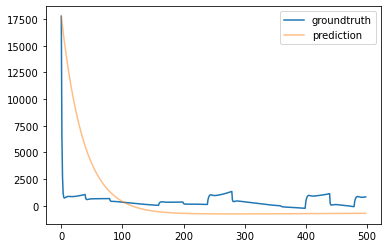

In [427]:
plot_pred(tables['train_p'], sanity_check)

## Train on train, val, and predict test

In [428]:
# Stack train, val and normalize
# concat train set with val set
train_data_dict = {}
for column in chosen_columns:
    train_data_dict[f'train_{column}'] = np.concatenate((tables[f'train_{column}'], tables[f'val_{column}']), axis=1)

In [429]:
# normalize each features 
normed_data, means, stds = {}, {}, {}
for key in train_data_dict:
    if key.startswith('train'):
        normed_data[key], means[key], stds[key] = normalize(train_data_dict[key])

17777.209433501135 16138.829614021564
5.320928173194436 4.906512359408766


In [430]:
normed_data.keys()

dict_keys(['train_p', 'train_U:2'])

In [431]:
normed_data['train_p'].shape

(17183, 598)

In [432]:
# stack data
train_data = stack_data(normed_data, 'train')

After stacking shape:  (34366, 598)


In [433]:
train_data.shape

(34366, 598)

In [434]:
prediction

array([[-1.00025245, -1.00551721, -1.01063926, ..., -1.17882576,
        -1.17916449, -1.17949294],
       [ 1.99439926,  1.99611934,  1.99781237, ...,  2.09595114,
         2.09669293,  2.09743208],
       [-1.0832889 , -1.08425139, -1.08518744, ..., -1.11514366,
        -1.11519369, -1.11524182],
       ...,
       [ 0.38518723,  0.38408321,  0.38299314, ...,  0.31064005,
         0.31000341,  0.30936756],
       [-1.10146647, -1.10147095, -1.10147524, ..., -1.10143704,
        -1.10143462, -1.10143219],
       [ 2.06906104,  2.07064713,  2.07220049, ...,  2.14349027,
         2.14386875,  2.1442437 ]])

In [435]:
scaled_predicted_p.shape

(17183, 401)

In [436]:
tables['test_p'].shape

(17183, 401)

In [437]:
predicted_p.shape

(17183, 99)

In [438]:
# train 
rom = prepare_data_and_train(train_data, best_basis, best_reg)

# predict
prediction = rom.predict(train_data[:,-1], np.arange(0.0598, 0.0999, 1e-4))   # predict from the last column of val data
predicted_p = post_process(prediction, means['train_p'], stds['train_p'])

tmp = mse(predicted_p, tables['test_p'], squared=False)

In [439]:
tmp  # 455.61986895953567   478.81477974255034

483.8987597939727

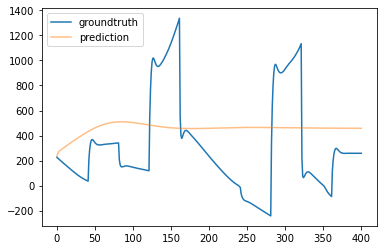

In [440]:
plot_pred(tables['test_p'], predicted_p)